In [27]:
import xarray as xr
import pandas as pd
import numpy as np
import scipy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import *
import matplotlib.colors as colors
import openpyxl
from netCDF4 import Dataset
import h5netcdf

In [28]:
sourceData='/bettik/amoryc/MARout/GRa/spin2/work/'
variable='TT' ##RF;SF;SHSN3;TT
fileNameM='mon-TT-MARv3.14_ER5-2000-2023.nc' ##change to monthly
dsM= xr.open_dataset(sourceData+fileNameM)['TT']

In [29]:
## Model MAR
sourceDataGrid='/home/amoryc/'
#fileName_grF='NST.2000.01.01.00.GRa_Fedchenko.nc'
fileName_grM='NST.2000.01.01.00.GRa_Mera.nc_ICEmask'
ds_grM= xr.open_dataset(sourceDataGrid+fileName_grM)

In [30]:
#Gra Mera 5km
sourceData='/bettik/amoryc/MARout/GRa/spin2/work/'
variable='TT' ##RF;SF;SHSN3;TT
fileNameM='mon-TT-MARv3.14_ER5-2000-2023.nc' ##change to monthly
dsM= xr.open_dataset(sourceData+fileNameM)['TT'][:,0,:,:] ## montlhy mean

In [31]:
###
#AWS-Mera La: Since November 2013 (AWS inserted on firm rocks – off-glacier)
#Location in WGS84, Lat: 27.735°N; Long: 86.900°E; Elevation: 5352.008 m 
#or UTM Zone 45; Easting: 490137.007 m; Northing: 3067850.613 m on 22/11/2020
###
lon_MeraLa=86.900
lat_MeraLa=27.735
elev_MeraLa=5352.008
##Find the pixel of MAR corresponding to station
target_lon = lon_MeraLa
target_lat = lat_MeraLa
lon=ds_grM.LON
lat=ds_grM.LAT

In [32]:
#Step 2: Find the nearest grid point to target_lon,target_lat
# Compute distance to each grid point
dist = np.sqrt((lon - target_lon)**2 + (lat - target_lat)**2)
print(dist)
j, i = np.unravel_index(dist.argmin(), dist.shape)

<xarray.DataArray (y: 116, x: 164)> Size: 76kB
array([[5.287968 , 5.240772 , 5.1936255, ..., 3.5945985, 3.6382864,
        3.6821296],
       [5.274055 , 5.2267156, 5.179424 , ..., 3.5731022, 3.6170528,
        3.6611905],
       [5.2604895, 5.2129927, 5.165556 , ..., 3.5520382, 3.5962706,
        3.640674 ],
       ...,
       [6.0885305, 6.0451493, 6.001897 , ..., 4.597399 , 4.633663 ,
        4.670207 ],
       [6.1141167, 6.0708904, 6.0278106, ..., 4.6302786, 4.666314 ,
        4.702625 ],
       [6.1399245, 6.0968695, 6.0539374, ..., 4.6633754, 4.6991653,
        4.735257 ]], shape=(116, 164), dtype=float32)
Coordinates:
  * x        (x) float32 656B -495.0 -490.0 -485.0 -480.0 ... 310.0 315.0 320.0
  * y        (y) float32 464B -195.0 -190.0 -185.0 -180.0 ... 370.0 375.0 380.0


In [33]:
print(j,i)

40 99


In [34]:
#Step 3: Extract data at that location
# For a single time step
#value = dsM['SH'].isel(y=j, x=i)
## If there's a time dimension
dsM_sta=dsM[0:, i, j]
dsM_sta_new2= dsM_sta.rename({'TIME': 'time'})
#units=dsM.units
dsM_sta_new= dsM_sta_new2.where(dsM_sta_new2.values <= 70)
#dsM_sta_new.values


In [35]:
#Evaluer la différence de hauteur entre la station et le niveau 1 de la grille MAR considérée
SH_sta=elev_MeraLa
value = ds_grM['SH'].isel(y=j, x=i)
diff=SH_sta-value.values
diff

np.float32(16.686035)

In [36]:
####
## Opening station data
####

In [37]:
sourceData='/bettik/PROJECTS/pr-regional-climate/santolam/glacioclim/donnees_meteo/'
fileName='MeraLafinal2013_24.xlsx'
xl_file = pd.ExcelFile(sourceData+fileName)
print(xl_file)

In [38]:
dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}
DataMeraLa=dfs['MeraLa2013_23']

NameVars=['Time','Tair','RH','u','Direction','SWin','SWout','LWin','LWout','Patm']
UnitVars=['data/hour','C','%','m/s','degrees','W/m2','W/m2','W/m2','W/m2','hPa']

##Define new DataFrame and changing name of columns
dfile = pd.DataFrame(data=DataMeraLa.loc[4:])
df=pd.DataFrame(dfile.values, columns=NameVars)

### Opening one column + converting into an array
Tair_ar=[float(i) for i in df.Tair.values]


In [39]:
##In original time data from DataFrame, frequency is not defined so I cannot use the usual fonction (xr,pd)
##Need to redefine a time array + build a xarray of variable V=V(time)
def NewTime(
        NameVar,
        Var_ar,
        freq):
    start, end = df.Time.values[0], df.Time.values[-1]
    time = pd.date_range(start, end, freq=freq)
    ds = xr.Dataset({NameVar: ("time",np.asarray(Var_ar)), "time": time})
    return ds 

In [40]:
#Définition Variables
T=NewTime('Tair',Tair_ar,'30min')


In [41]:
daily_meanT=T.resample(time='D').mean()                          #Utilisation de la librairie xarray maintenant possible car les données ont une forme bien définie
monthly_meanT=daily_meanT.resample(time='ME').mean()             # chaque variable ici défini est un xarray.Dataset
yearly_meanT=monthly_meanT.resample(time='YE').mean()
#daily_meanTM

In [42]:
#Définition des Saisons, et création d'une fonction qui définit les saisons en fonction des périodes des moussons:
seasons = {
	'MAM': [3, 4, 5],  	
	'JJAS': [6, 7, 8, 9],  
	'ON': [10, 11],    	
	'DJF': [12, 1, 2]  	
}
def seasonsdata(ds, season_name):  #monthly_meanTM.sel(time=monthly_meanTM['time'].dt.month.isin(seasons['MAM'])). Sélectionne dans le dataset les mois correspondants aux saisons définies au dessus

	x = seasons[season_name]
	return ds.sel(time=ds['time'].dt.month.isin(x))


In [43]:
# Get the time coordinates CORRIGER DIFF ENTRE MAR ET STATION
time1 = monthly_meanT['time']# début 2013-11-15 fin 2024-11-28
time2 = dsM_sta_new['time'] # début 2003-01-01T12: fin 2013-12-31T12
start=time1[0] 
end=time2[-1]

In [44]:
ts_sta=monthly_meanT.sel(time=slice(start,end))
ts_MAR=dsM_sta_new.sel(time=slice(start,end))

#Annual cycle:
Tsta_cycle=ts_sta.groupby('time.dayofyear').mean()

TMAR_daily_cycle=ts_MAR.groupby('time.dayofyear').mean()
plt.plot(Tsta_daily_cycle.dayofyear,Tsta_daily_cycle.Tair,     
    color='darkblue',linestyle='-',label='Tair')
plt.title('Mean annual cycle of daily surface Temperatures')
plt.xlabel('Day of year')
plt.ylabel('Température (°C)')
#Annual cycle:
plt.plot(TMAR_daily_cycle.dayofyear,TMAR_daily_cycle.values,    
    color='red',linestyle='-',label='Tair MAR')
plt.legend()
plt.grid(True)




In [45]:
Tsta_monthly_cycle=monthly_meanT.groupby('time.month').mean()
TMAR_monthly_cycle=dsM_sta_new.groupby('time.month').mean()

In [46]:
Tsta_premon = seasonsdata(monthly_meanT, 'MAM').groupby('time.month').mean()

Tsta_mon = seasonsdata(monthly_meanT, 'JJAS').groupby('time.month').mean()

Tsta_postmon =  seasonsdata(monthly_meanT, 'ON').groupby('time.month').mean()

Tsta_hiver  = seasonsdata(monthly_meanT, 'DJF').groupby('time.month').mean()


In [47]:
#dsM_sta_new


TMAR_premon = seasonsdata(dsM_sta_new, 'MAM').groupby('time.month').mean()

TMAR_mon = seasonsdata(dsM_sta_new, 'JJAS').groupby('time.month').mean()

TMAR_postmon =  seasonsdata(dsM_sta_new, 'ON').groupby('time.month').mean()

TMAR_hiver  = seasonsdata(dsM_sta_new, 'DJF').groupby('time.month').mean()





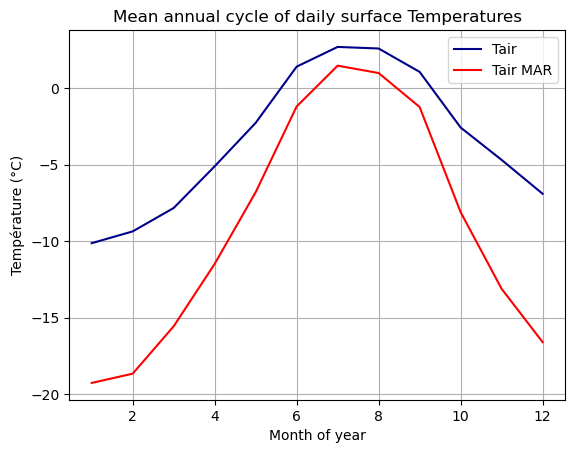

In [48]:
#Monthly cycle

plt.plot(Tsta_monthly_cycle.month,Tsta_monthly_cycle.Tair,
    color='darkblue',linestyle='-',label='Tair')

plt.plot(TMAR_monthly_cycle.month,TMAR_monthly_cycle.values,
    color='red',linestyle='-',label='Tair MAR')
plt.legend()
plt.title('Mean annual cycle of daily surface Temperatures')
plt.xlabel('Month of year')
plt.ylabel('Température (°C)')

plt.grid(True)

Text(0, 0.5, 'Negative T Bias (°C)')

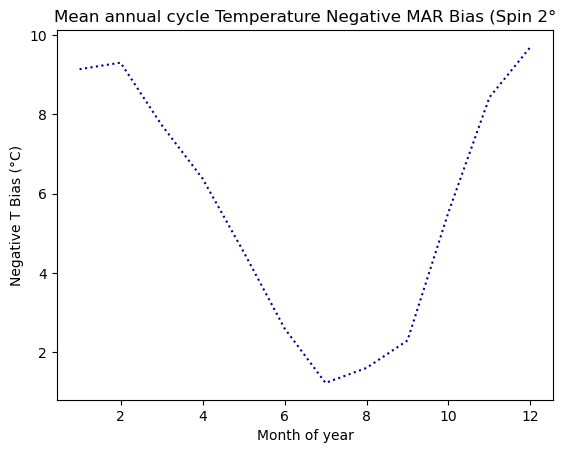

In [49]:
#MAR BIAS over Monthly mean data:
plt.plot(TMAR_monthly_cycle.month, Tsta_monthly_cycle.Tair-TMAR_monthly_cycle.values,
         color='darkblue',linestyle=':',label='Tair;'+'MAR')
plt.title('Mean annual cycle Temperature Negative MAR Bias (Spin 2°')
plt.xlabel('Month of year')
plt.ylabel('Negative T Bias (°C)')


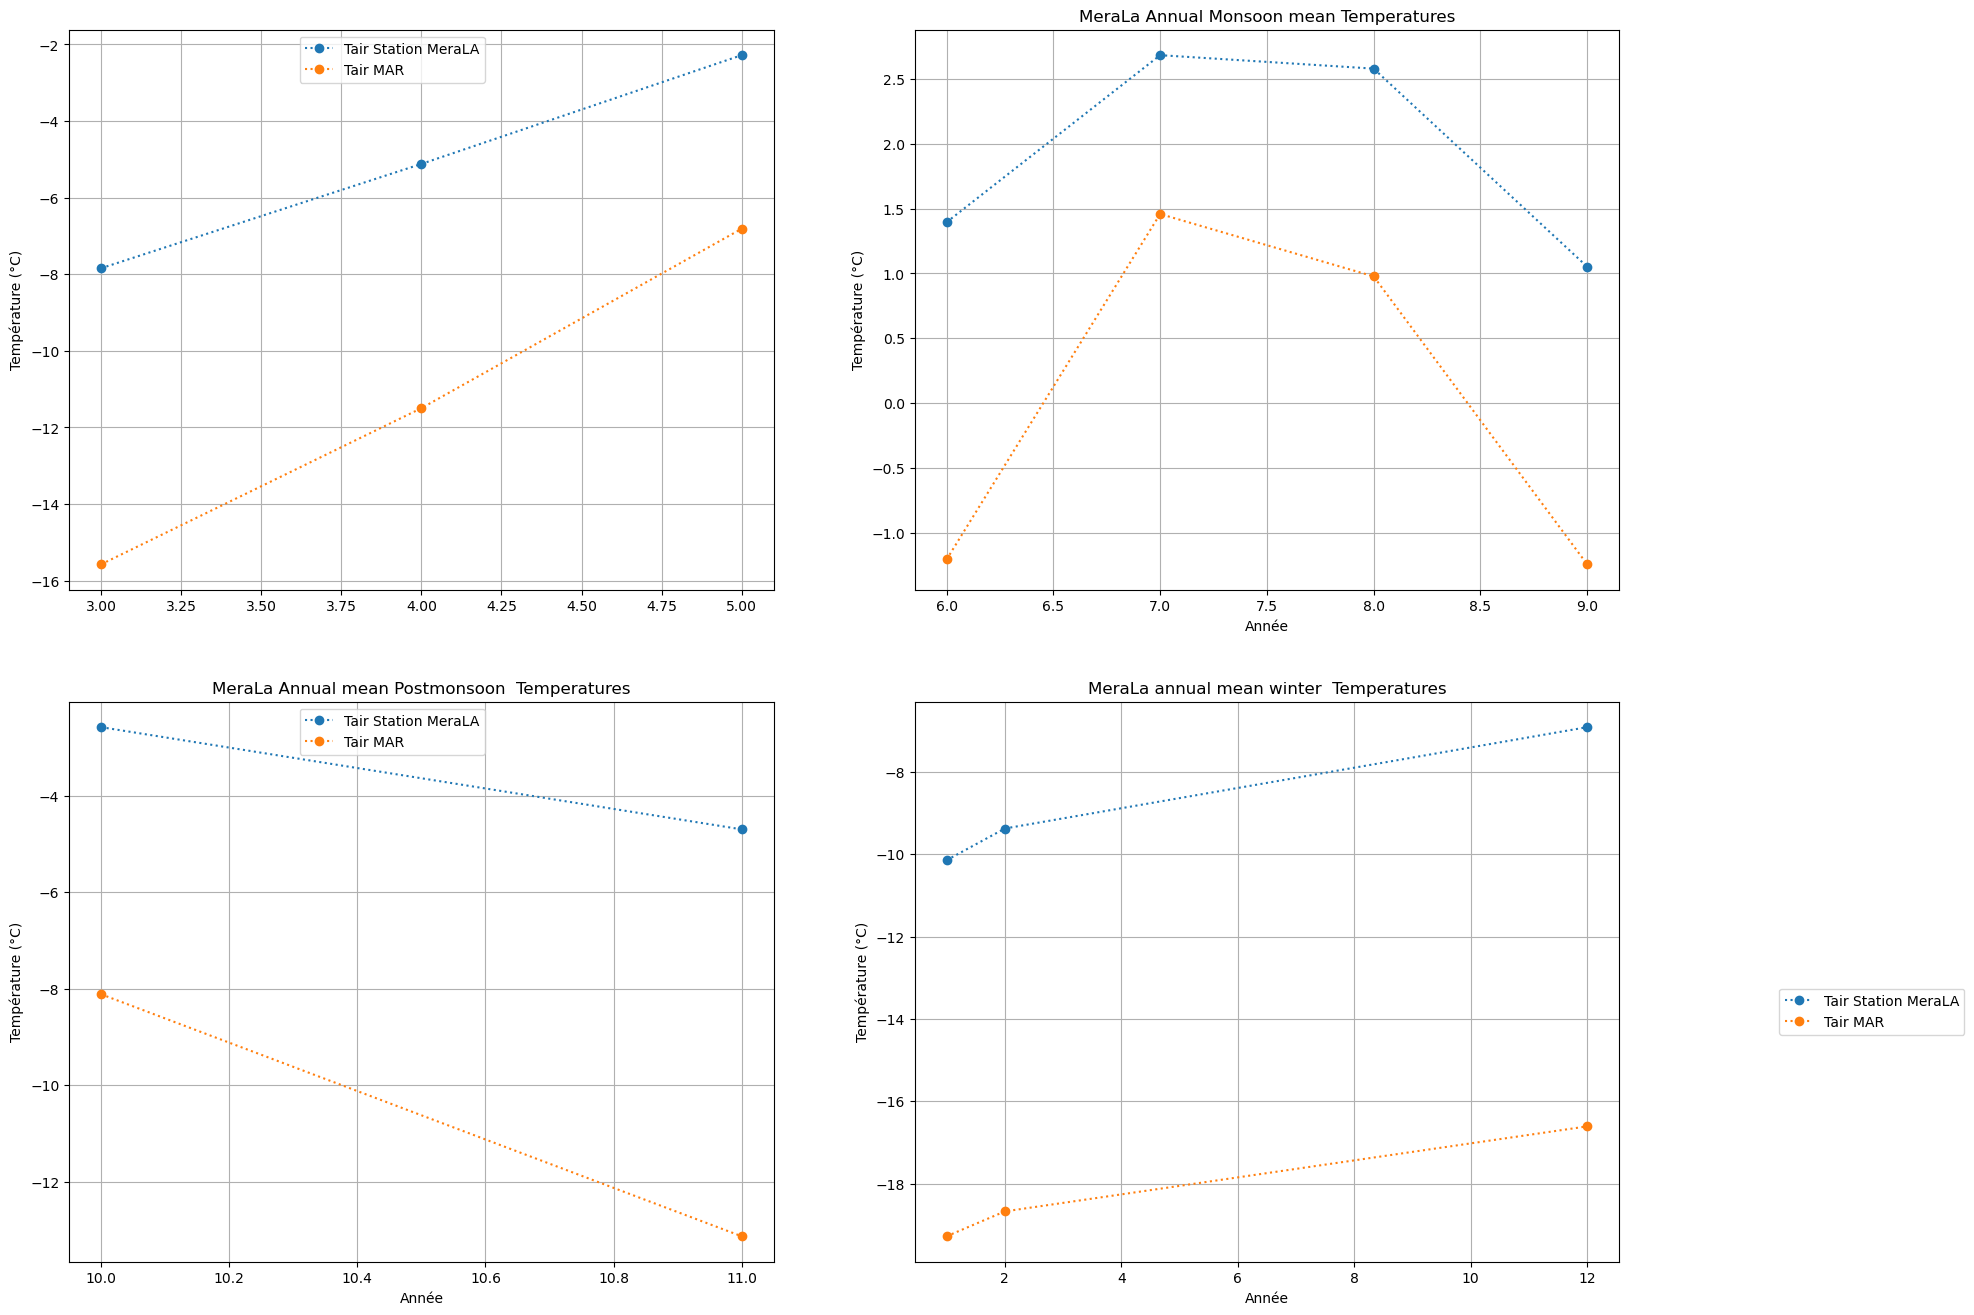

In [50]:
#Ajout incertitudes, 

fig, ((ax1,ax2) , (ax3,ax4)) = plt.subplots(2,2, figsize=(20,16))
ax1.plot(Tsta_premon.month, Tsta_premon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLA')
ax1.plot(TMAR_premon.month, TMAR_premon.values, linestyle=':', marker= 'o', label='Tair MAR')
ax1.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('Température (°C)')
ax1.grid()

ax2.plot(Tsta_mon.month, Tsta_mon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLA')
ax2.plot(TMAR_mon.month, TMAR_mon.values, linestyle=':', marker= 'o', label='Tair')
ax2.set_title('MeraLa Annual Monsoon mean Temperatures')
ax2.set_xlabel('Année')
ax2.set_ylabel('Température (°C)')
ax2.grid()

ax3.plot(Tsta_postmon.month, Tsta_postmon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLA')
ax3.plot(TMAR_postmon.month, TMAR_postmon.values, linestyle=':', marker= 'o', label='Tair MAR')
ax3.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax3.set_title('MeraLa Annual mean Postmonsoon  Temperatures')
ax3.set_xlabel('Année')
ax3.set_ylabel('Température (°C)')
ax3.grid()

ax4.plot(Tsta_hiver.month, Tsta_hiver['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLA')
ax4.plot(TMAR_hiver.month, TMAR_hiver.values, linestyle=':', marker= 'o', label='Tair MAR')
ax4.legend(bbox_to_anchor=(1, 0, 0.5, 0.5)) 
ax4.set_title('MeraLa annual mean winter  Temperatures')
ax4.set_xlabel('Année')
ax4.set_ylabel('Température (°C)')
ax4.grid()